# Logistic Regression:

This Jupyter Notebook is dedicated to understanding and implementing the logistic regression on a single neuron for soccer data. You can find the dataset [2022-2023 Soccer Player Stats Dataset](https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats?resource=download).

The following packages are required to run the attached code:

- [Pandas](https://pandas.pydata.org/docs/)

- [Matplotlib.pylab](https://matplotlib.org/2.0.2/api/pyplot_api.html)

- [Numpy](https://numpy.org/doc/)

- [Seaborn](https://seaborn.pydata.org/)

- [SciKit Learn](https://scikit-learn.org/stable/)

## Description of the Algorithm:

***
In a previous notebook, I implemented the single neuron perceptron algorithm. This algorithm worked great for binary classification, but it only works when dividing the data linearly. For more complex data that cannot be split linearly, we can use logistic regression!

Here is an example of what logistic regression looks like:

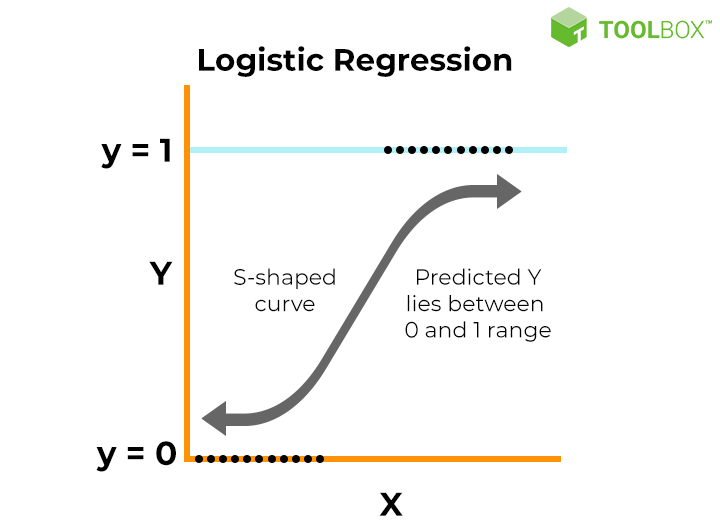

As described in the photo, the logistic function transforms the output of a linear combination of input features into a probability score between 0 and 1, which represents the likelihood of the instance belonging to the positive class. 

By setting a decision threshold, typically 0.5, logistic regression classifies instances as either positive or negative based on their predicted probabilities. 

The use of probabilities allows us to make accurate predictions on datasets that aren't linearly seperable. 

Image source: [SpiceWorks](https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-logistic-regression/). 

***

## Logistic vs. Linear Regression:

***
Where linear regression worked with continuous data, logistic regression perfoms classification. Unlike linear regression, which predicts continuous values, logistic regression models the probability of the binary outcome using a logistic (or sigmoid) function. 

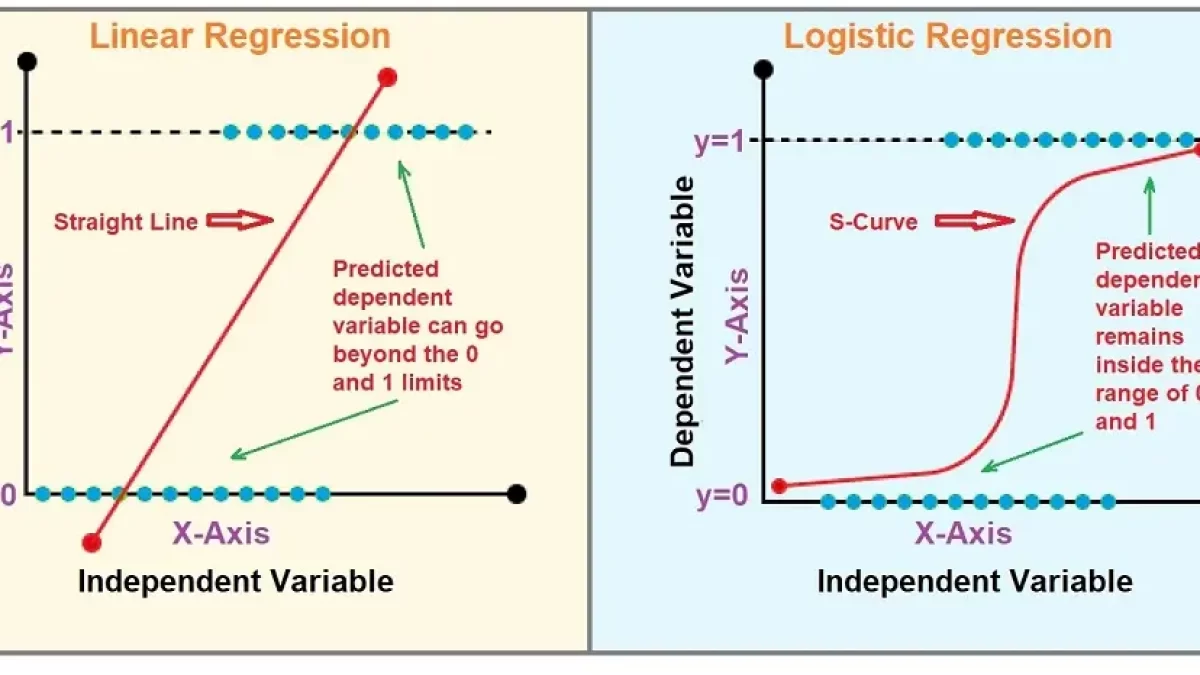

Still, despite their differences, linear and logistic regression are similar (in fact, logistic regression was adapted from linear regression). The key difference, though, is the sigmoid function that allows logistic regression to capture complex classification problems.

Image source [EJable](https://www.ejable.com/tech-corner/ai-machine-learning-and-deep-learning/logistic-and-linear-regression/).
***

## Sigmoid Activation:

***
The sigmoid activation function, also known as the logistic function, is a mathematical function used in logistic regression to model the probability that a given input belongs to a specific class. It takes any real-valued number and maps it to a value between 0 and 1, making it suitable for binary classification tasks. The formula for the sigmoid function is given by:

$
\sigma(z) = \frac{1}{1 + e^{-z}}
$

Where $z$ is the input to the function. Note that as z increases, $\sigma(z)$ approches 1 and as z decreases, $\sigma(z)$ approaches 0. This is how we get the probabilities of being in each of the two classes. 
***

## Setting Up:

***
Import the necessary modules.
***

In [3]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

***
Read in the data. We will be using shots as the predictor and goals as the response.
***

In [4]:
#Import the dataset. 
soccer = pd.read_csv("/Users/pstern/Desktop/INDE-577/Datasets/soccer_stats.csv", encoding='ISO-8859-1', delimiter=';')

# Filter the data such that we are only including players who have player more than 7.4 games worth of time.
data = soccer[soccer['90s'] >= 7.5]

# Filter to just include defenders and forwrds.
data = soccer[(soccer['Pos'] == 'FW') | (soccer['Pos'] == 'DF')]

# Take out players with 0 shots so we can take a log transformation.
data = data[(data['Shots'] != 0)]

# Get the forwards and defenders.
forward = data[data['Pos'] == 'FW']
defender = data[data['Pos'] == 'DF']

# Get the shots for forwards and defenders to use as a predictor.
fw_shots = forward['Shots'].values
df_shots = defender['Shots'].values

# Take a log transformation of shots.
fw_shots_log = np.log(fw_shots)
df_shots_log = np.log(df_shots)

# Select clearances as a predictor.
fw_90s = forward['90s'].values
df_90s = defender['90s'].values

# Get the data for our model
predictors = data[['Shots', '90s']].values
response = [[int(val)] for val in (data['Pos'] == 'FW')]
response = np.ravel(response)
shots = np.log(data['Shots']).values

# Split the data into training and testing sets.
train_p, test_p, train_r, test_r = train_test_split(predictors, response, test_size = 0.4, random_state = 42)

# Split the single variable predictor into two. 
train_shots, test_shots, train_r1, test_r1 = train_test_split(shots, response, test_size = 0.4, random_state = 42)

***
Note: taking a log transformation doesn't make much sense from a data processing sense here, I am doing it for the sake of example.
***

***
Plot the data to determine if we can, in fact, perform binary classification.
***

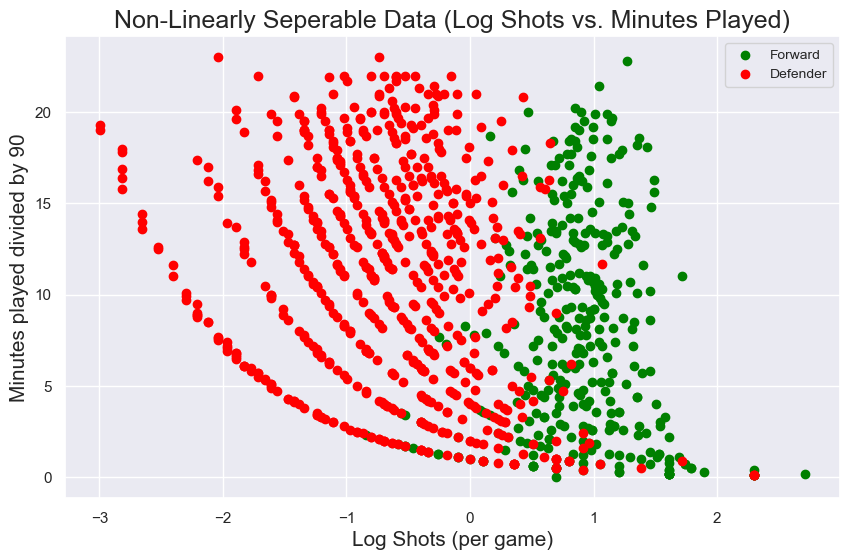

In [5]:
# Set the theme. 
sns.set_theme()

plt.figure(figsize = (10, 6))

# Add the red card players to the plot.
plt.scatter(fw_shots_log, fw_90s, color = "green", label = "Forward")

# Add the non red card players to the plot.
plt.scatter(df_shots_log, df_90s, color = "red", label = "Defender")
plt.xlabel("Log Shots (per game)", fontsize = 15)
plt.ylabel("Minutes played divided by 90", fontsize = 15)
plt.legend(fontsize = 10, loc = "upper right")
plt.title("Non-Linearly Seperable Data (Log Shots vs. Minutes Played)", fontsize = 18)
plt.show()

Note that the split in the data is not extrememly clear and there is some overlap. I am curious to see how the algorithm handles this. 

***
Also, plot shots on target vs. goals for when we do logistic regression on a single variable. 
***

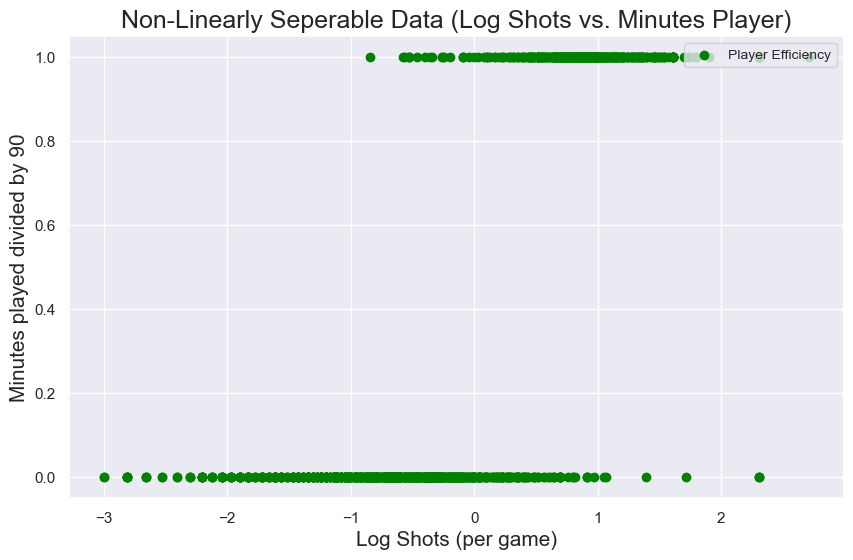

In [6]:
# Set the theme. 
sns.set_theme()

# Set the figure size. 
plt.figure(figsize = (10, 6))

# Add the players to the graph
plt.scatter(shots, response, color = "green", label = "Player Efficiency")
plt.xlabel("Log Shots (per game)", fontsize = 15)
plt.ylabel("Minutes played divided by 90", fontsize = 15)
plt.legend(fontsize = 10, loc = "upper right")
plt.title("Non-Linearly Seperable Data (Log Shots vs. Minutes Player)", fontsize = 18)
plt.show()

Again, we can clearly see some overlap in the data as the log shot values do not seem to be a perfect indicator of if a player is an attacker or defender.

## Let's try to do the Split with Perceptron:

***
Analyze the data.
***

The data isn't perfectly split, but it's hard to find something that is perfect in soccer data because of things like corners, free kicks, and penalties where many players tend to shoot. This will just have to be a challenge for the logistic regression algorithm!

In this set, there seems to be a clear trend in where each set of data lies (the forwards seem to have been shifted to the right), while the goal scoring playes have a varying number of minutes played but larger numbers of shots on target. 

There also doesn't seem to be a viable linear split as, after the log transformation, there seems to be a swell in shots for players with less playing time. If we used the perceptron algorithm, as you will see below, it would not fully capture the spread ofthe data. 

***
Implement the perceptron algorithm for comparison. We will use shots on target as a predictor for goals. 
***

In [7]:
# A class that represents a single perceptron neuron. 
class Perceptron(object):
    '''
    Class Attributes:

    eta : float
        The learning rate used in training the perceptron.

    epochs : int
        The number of epochs for training the perceptron.

    w_ : numpy.ndarray
        The weights and bias of the single neuron. The last entry represents the bias.

    errors_: list
        A list containing the number of misclassifications after each epoch of training.
    '''
    # Initialize Perceptron object.
    def __init__(self, eta = .5, epochs=50):
        self.eta = eta
        self.epochs = epochs
        
    def train(self, X, y):
        '''
        Trains the perceptron using the provided feature vectors X and associated labels y.
        '''
        # Initialize random weights.
        self.weight = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        
        # Iterate through the epochs.
        for _ in range(self.epochs):
            errors = 0

            # Iterate through each sample in the training set.
            for xi, target in zip(X, y):

                # Update weights based on the difference between predicted and actual class.
                update = self.eta * (self.predict(xi) - target)
                self.weight[:-1] -= update * xi
                self.weight[-1] -= update

                #Keep track of the number of errors.
                errors += int(update != 0)

            # If there are no errors in this epoch, return.
            if errors == 0:
                return self
            else:
                self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        '''
        A helper function that calculates the net input for a given feature vector X.
        '''
        # Calculate net input (sum of weighted inputs plus bias).
        return np.dot(X, self.weight[:-1]) + self.weight[-1]
    
    
    def predict(self, X):
        '''
        Predicts the class labels for the input feature vectors X after training.
        '''
        # Predict class labels based on net input.
        return np.where(self.net_input(X) >= 0.0, 1, -1)

***
Let's get the prediction error using perceptron. Do we even need logistic regression?
***

In [8]:
# Instantiate an instance of the Perceptron class.
ptron = Perceptron(epochs = 500)

# Train the model.
ptron.train(train_shots.reshape(-1,1), train_r1)

# Predict make predictions based on training.
y_hat = ptron.predict(test_shots.reshape(-1,1))

# Compare our predictions with reality.
sum = 0
for i in range(len(y_hat)):
    if y_hat[i] != test_r1[i]:
        sum += 1

print(f"Error Percent = {round(((sum / len(y_hat)) * 100), 2)}%")


Error Percent = 65.06%


This is clearly not good as our predictions were only accurate for our data as it made the wrong prediction 65% of the time. We can do better with logistic regression!

## Description of the Logistic Regression algorithm:

***
To account for non linearity, we go from predicting class as a binary to defining a probability for it being in each class using a single neuron model.

For logistic regression, we use the sigmoid activation function instead of just a simple linear one. This function is of the form $\sigma (z)  = 1 / (1 + e^{-z})$. This function is well equipped to handle non-linear binary classification because the sigmoid function has a range of (0,1), the exact values we look for when dealing with probabilities. Further, the sigmoid function is s-shaped allowing it to better capture more complex data that cannot just be separated linearly. 
***

## Deriving the Logistic Regression Model:

***
We now implement a new cost function to adress our objective -- performing classification.

Here is the cost function we use: $C(w_1, b; x^{(i)},y^{(i)}) = -y^{(i)}\log \hat{y}^{(i)} - (1-y^{(i)}) \log (1 - \hat{y}^{(i)})$

This function is a good choice because it is differntiable and enables us to make predictions based on probabilities (between 0 and 1).

Following the same form as linear regression, we continuously improve our model based on past training iterations. 

This means $\hat y^(i)$ becomes $\hat{y}^{(i)} = \sigma(z) = \sigma(w_1x^{(i)} + b)$ allowing us to write, simply, $\sigma'(z) = \sigma(z)(1 - \sigma(z))$, which we will use later.

Now, like normal, we must compute the partial derivatives will respect to the weights and bias, allowing us to perform gradient descent.

And, with that, we are ready to implement our algorithm. You may notice that we seem to have all the same puzzle pieces as linear regression, this time, they are just tuned to work for classification.



***

## Implementing Logistic Regression:

***
Implement the single neuron model for logistic regression. We will use shots on target as the predictor for goals. 
***

In [9]:
# Implement a single neuron logistic regression model.
class SingleNeuron(object):
    '''
    Class Attributes:
    activation_function : function
        The activation function applied to the preactivation linear combination -- the sigmoid activation function!
    
    cost_function : function
        The cost function used to measure model performance.

    w_ : numpy.ndarray
        The weights and bias of the single neuron.

    errors_: list
        A list containing the mean sqaured error computed after each iteration after each epoch.
    '''
    # Initialize the class objects.
    def __init__(self, activation_function, cost_function):
        self.activation_function = activation_function
        self.cost_function = cost_function

    # Train the model. 
    def train(self, X, y, alpha = 0.005, epochs = 50):
        '''
        Trains the classification model using the provided feature vectors X and associated labels y.
        '''
        # Initialize the weights.
        self.w_ = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        N = X.shape[0]

        #Iterate through the epochs.
        for _ in range(epochs):
            errors = 0
            # Iterate through the data points.
            for xi, target in zip(X, y):
                error = (self.predict(xi) - target)
                self.w_[:-1] -= alpha*error*xi
                self.w_[-1] -= alpha*error
                errors += self.cost_function(self.predict(xi), target)
            self.errors_.append(errors/N)
        return self

    # Predict the output.
    def predict(self, X):
        '''
        Predicts the class labels for the input feature vectors X after training.
        '''
        preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
        return self.activation_function(preactivation)

    # Plot the cost function.
    def plot_cost_function(self):
        '''
        Creates a plot of the cost function for interpretation. 
        '''
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.errors_) + 1), 
                self.errors_,
                label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    # Plot the decision boundary.
    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        '''
        Plots the decision boundary for the data.
        '''
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()

def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def cross_entropy_loss(y_hat, y):
    return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

***
Train the single input neuron.
***

In [10]:
# Instantiate the mdoel.
node = SingleNeuron(sigmoid, cross_entropy_loss)

# Train the model. 
node.train(train_shots.reshape(-1,1), train_r1, alpha = 0.01, epochs = 1000)

***
Let's visualize the "cost" at each epoch to see if our algorithm is improving at each epoch.
***

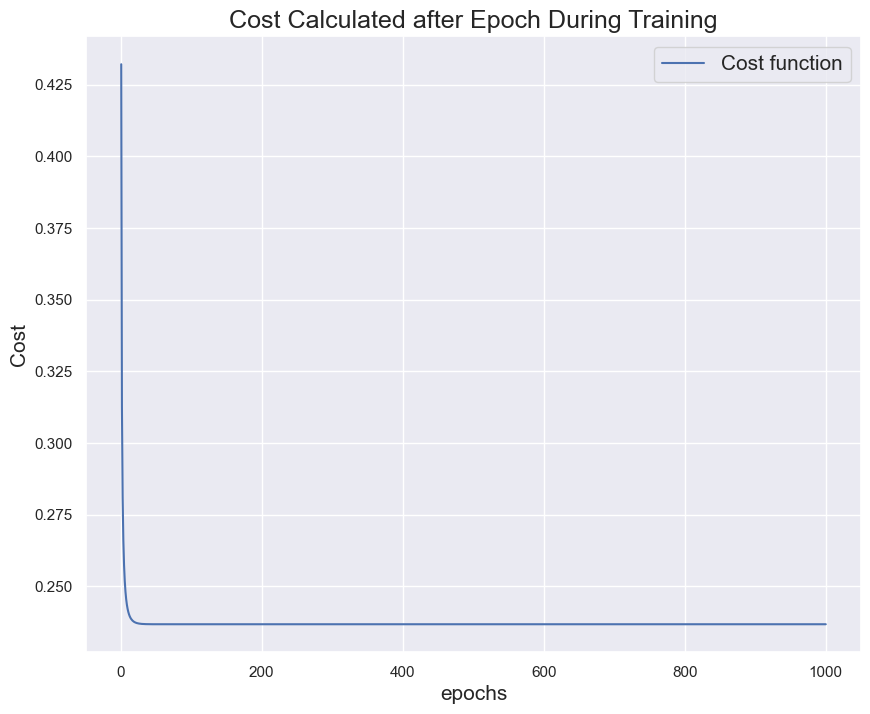

In [11]:
# Plot the cost function.
node.plot_cost_function()
plt.show()

The cost decreases rapidly in the first 100 epochs and then slowed afterwards. I initally ran the training data for 10,000 epochs but substantial change seemed to stop after the first 2000.

***
Now, let's get the error percent for logistic regression.
***

In [14]:
# Get the predictions.
y_hat = node.predict(train_shots.reshape(-1,1))

# Get the error percent.
error = (np.rint(y_hat) != train_r1).astype(int)
print(f"Error Percent = {round(((error.sum() / len(train_r1)) * 100), 2)}%")

Error Percent = 8.04%


We are now doing much better! An 8% error rate isn't perfect, but it seems great given the amount of overlap between the groups in the data (see the first graph). I am genuinely very impressed. 

***
Let's plot the decision boundary to get a better look at the split. 
***

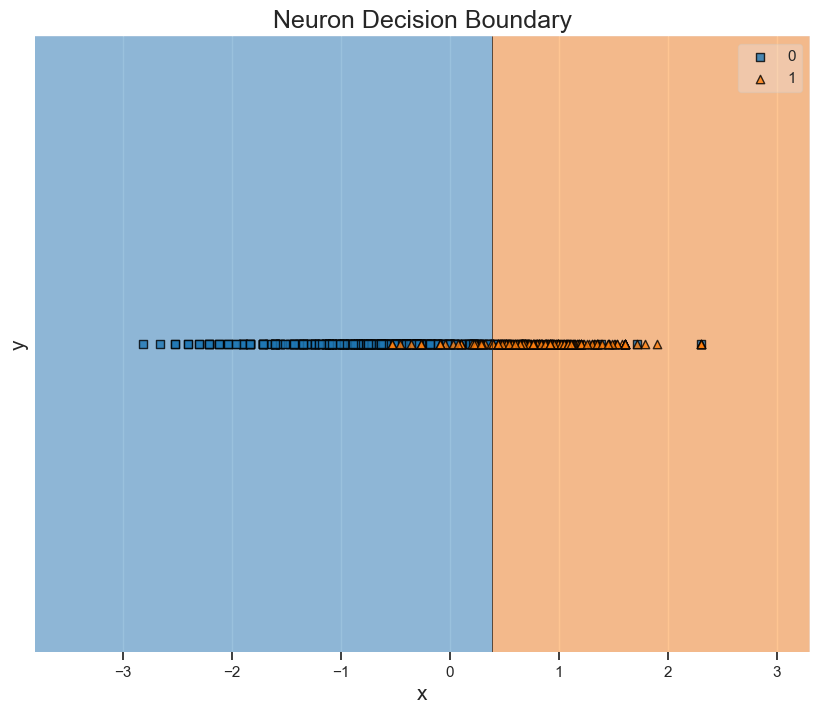

In [18]:
# Plot the decision boundary.
node.plot_decision_boundary(train_shots.reshape(-1,1), train_r1)
plt.show()

Again, there is definitely some overlap, but generally, the model does well.

***
Let's try the regression model on the test data as well!
***

In [19]:
# Get the predictions.
y_hat = node.predict(test_shots.reshape(-1,1))

# Get the error percent.
error = (np.rint(y_hat) != test_r1).astype(int)
print(f"Error Percent = {round(((error.sum() / len(test_r1)) * 100), 2)}%")

Error Percent = 8.19%


Wow! This is slightly worse but still very, very low given the data.

## We can also do single neuron logistic regression with multiple inputs:

***
Now we will use both touches and shots on target as predictors. 
***

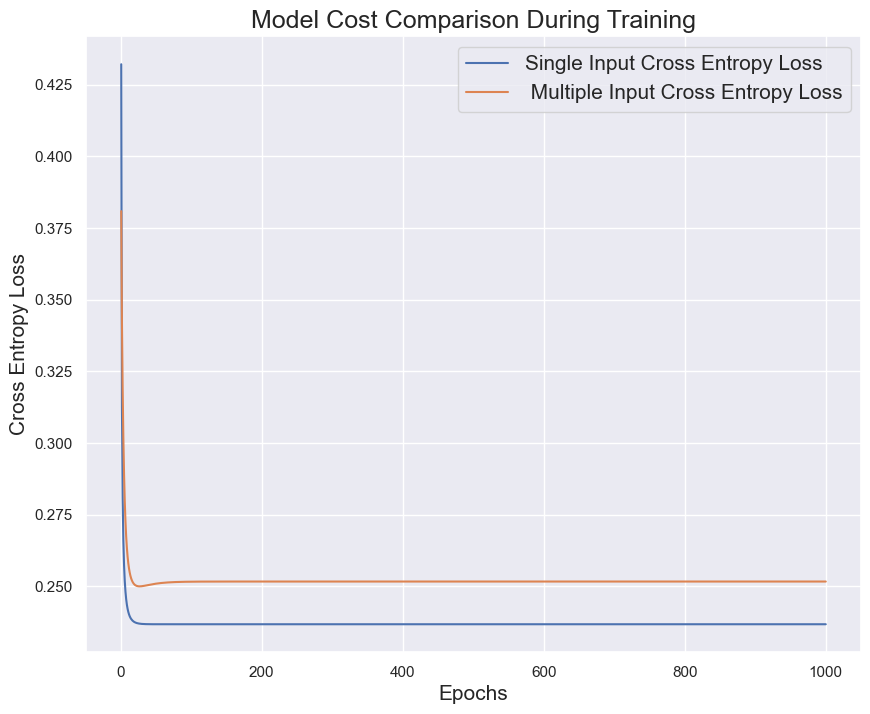

In [24]:
# Instantiate a new single neuron.
mul_node = SingleNeuron(sigmoid, cross_entropy_loss)

# Train the new single neuron model on the new feature vectors.
mul_node.train(train_p, train_r, alpha = 0.01, epochs = 1000)

# Plot the cost function.
plt.figure(figsize = (10, 8))
plt.plot(range(1, len(node.errors_) + 1), node.errors_, label = "Single Input Cross Entropy Loss")
plt.plot(range(1, len(mul_node.errors_) + 1), mul_node.errors_, label = " Multiple Input Cross Entropy Loss")
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Cross Entropy Loss", fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Model Cost Comparison During Training", fontsize = 18)

plt.show()

Interestingly, the model does worse when we begin to incorporate the additional input. This shows the importance of only choosing predictors that actually reflect the data. In many cases, adding more (good) predictors makes our models better.

***
Let's plot the decision boundary. 
***

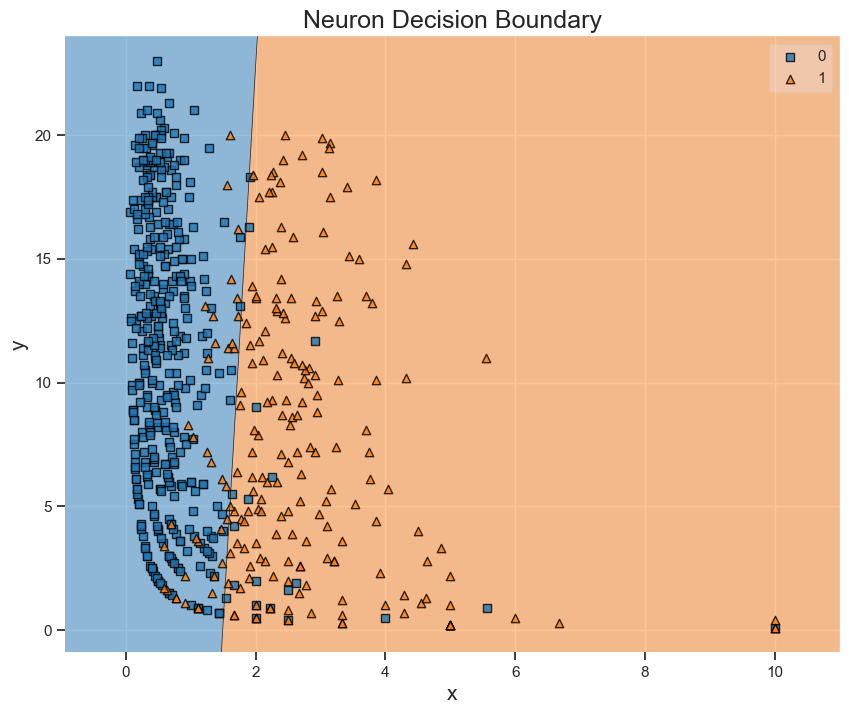

In [25]:
# Plot the decision boundary.
mul_node.plot_decision_boundary(train_p, train_r)

This looks good! You can see some overlap in the outliers, but for the most part this looks good. 

***
Let's see how the multiple input model does on the test data.
***

In [29]:
# Get the predictions.
y_hat = mul_node.predict(test_p)

# Get the error percent.
error = (np.rint(y_hat) != test_r).astype(int)
print(f"Error Percent = {round(((error.sum() / len(test_r)) * 100), 2)}%")

Error Percent = 8.43%


Despite getting a worse MSE, the multiple node model still does very well. Still, is it slightly worse than the single input node.  